In [1]:
import os
os.environ["SPS_HOME"] = "/Users/fpetri/packages/fsps" 

import numpy as np
from prospect.models.templates import TemplateLibrary
from prospect.models import SpecModel
import prospect.models.transforms as transforms
import prospect.plotting.utils as utils
import matplotlib.pyplot as plt
from prospect.sources import CSPSpecBasis

In [2]:
model_params = TemplateLibrary["beta"]
model = SpecModel(model_params)
sps = CSPSpecBasis(zcontinuous=1)
print(sps.ssp.libraries)
print(model)

(b'mist', b'miles', b'DL07')
:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=4.0)
  duste_umin: <class 'prospect.models.priors.TopHat'>(mini=0.1,maxi=25)
  duste_qpah: <class 'prospect.models.priors.TopHat'>(mini=0.5,maxi=7.0)
  duste_gamma: <class 'prospect.models.priors.LogUniform'>(mini=0.001,maxi=0.15)
  fagn: <class 'prospect.models.priors.LogUniform'>(mini=1e-05,maxi=3.0)
  agn_tau: <class 'prospect.models.priors.LogUniform'>(mini=5.0,maxi=150.0)
  dust_ratio: <class 'prospect.models.priors.ClippedNormal'>(mean=1.0,sigma=0.3,mini=0.0,maxi=2.0)
  dust_index: <class 'prospect.models.priors.TopHat'>(mini=-2.0,maxi=0.5)
  nzsfh: <class 'prospect.models.priors_beta.NzSFH'>(zred_mini=0.001,zred_maxi=15.0,mass_mini=7.0,mass_maxi=12.5,z_mini=-1.98,z_maxi=0.19,logsfr_ratio_mini=-5.0,logsfr_ratio_maxi=5.0,logsfr_ratio_tscale=0.3,nbins_sfh=7,const_phi=True)

Fixed Parameters: (na

(array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

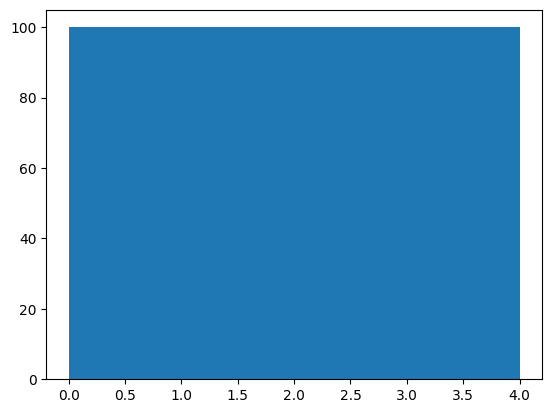

In [3]:
samples = utils.sample_prior(model, 1000)[0]
plt.hist(samples[:,0])

In [4]:
meow = samples[:, -1]
meow.shape
#transforms.nzsfh_to_zred(meow)

(1000,)

In [20]:
from prospect.models import priors_beta as pb
prior = pb.PhiSFH(zred_mini=0.01, zred_maxi=7.0, mass_mini=7.0, mass_maxi=13.0,
                z_mini=-2.5, z_maxi=0.5,
                logsfr_ratio_mini=-5.0, logsfr_ratio_maxi=5.0,
                logsfr_ratio_tscale=0.3, nbins_sfh=7,
                const_phi=True)


nsamples = 10000
prior_samples = []
for i in range(nsamples):
    prior_samples.append(prior.sample())

samples = np.vstack(np.array(prior_samples))
print(samples.shape) #z, mass, met, sfrs
print(samples[0, :])

(10000, 9)
[ 6.70975033  7.1790984   0.23795717 -0.29661553  0.93547504  0.72267632
  0.73355973  1.08212998  0.7036052 ]


(array([1.673e+00, 8.970e-01, 7.920e-01, 6.730e-01, 6.280e-01, 6.020e-01,
        4.700e-01, 4.580e-01, 4.500e-01, 3.400e-01, 3.090e-01, 2.880e-01,
        2.760e-01, 2.750e-01, 2.220e-01, 1.800e-01, 1.630e-01, 1.480e-01,
        1.390e-01, 1.210e-01, 1.200e-01, 9.700e-02, 9.100e-02, 7.500e-02,
        7.300e-02, 5.000e-02, 5.800e-02, 5.100e-02, 3.500e-02, 2.400e-02,
        4.200e-02, 2.300e-02, 2.700e-02, 2.400e-02, 2.100e-02, 2.300e-02,
        1.900e-02, 7.000e-03, 1.100e-02, 9.000e-03, 6.000e-03, 2.000e-03,
        2.000e-03, 1.000e-03, 3.000e-03, 2.000e-03, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([ 7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,  7.8,  7.9,  8. ,
         8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,  8.9,  9. ,  9.1,
         9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9, 10. , 10.1, 10.2,
        10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.

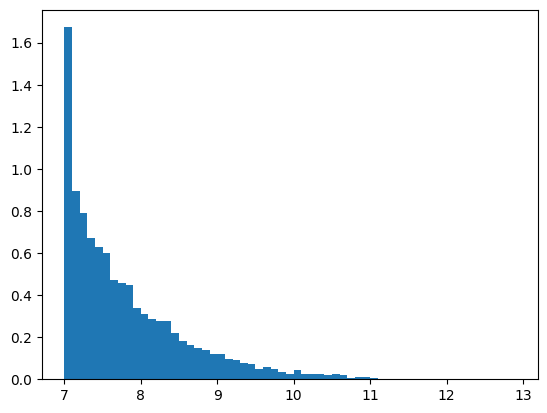

In [21]:
zbins = np.arange(7, 13, 0.1)
plt.hist(samples[:, 1], density=True, bins=zbins)

In [4]:
from prospect.models import priors_beta as pb
from scipy.stats import t
import numpy as np

nsamples = 100
redshift = np.ones(nsamples)
mass = np.ones(nsamples)*9.0
log_sfr_rations_means = []
for n in range(nsamples):
    log_sfr_rations_means.append(pb.expe_logsfr_ratios(redshift[n], mass[n], -5.0, 5.0))

logsfr_ratios_rvs = t.rvs(df=2, loc=log_sfr_rations_means, scale=0.3)
logsfr_ratios_rvs = np.clip(logsfr_ratios_rvs, a_min=-5.0, a_max=5.0)

logsfr_ratios_rvs.shape

(100, 6)

(10000, 9)
[ 2.24934246  7.1042431  -0.62608    -0.1119696  -0.62695139 -0.46277375
  0.57475883  0.66876685  1.09941725]
[2.24934246 1.87613302 3.76834993 ... 0.43127846 5.08398664 2.42961482]
[[-0.1119696  -0.62695139 -0.46277375  0.57475883  0.66876685  1.09941725]
 [ 0.35501839  2.54455428  0.0920937   0.36854125  0.43313792  1.06072732]
 [-0.20926488  0.13170054 -0.24315794  1.10270482  0.94062905  1.18904066]
 ...
 [-0.37420322 -0.00669346 -1.08731805 -0.08595419  0.84666956  0.65573345]
 [-0.26981105  1.28888113  0.49811855  0.04468409  0.76145546  0.98164924]
 [-0.41894435  0.16148739  0.27543319  0.27679877  0.78894989  1.26942929]]


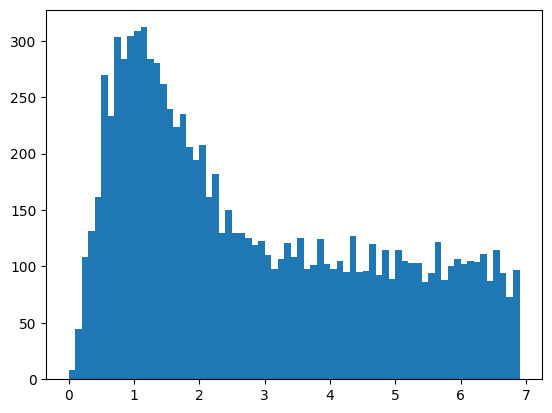

In [12]:
from prospect.models import priors_beta as pb
import numpy as np
import matplotlib.pyplot as plt

prior = pb.NzSFH(zred_mini=0.01, zred_maxi=7.0, mass_mini=7.0, mass_maxi=13.0,
                z_mini=-2.5, z_maxi=0.5,
                logsfr_ratio_mini=-5.0, logsfr_ratio_maxi=5.0,
                logsfr_ratio_tscale=0.3, nbins_sfh=7,
                const_phi=True)


zbins = np.arange(0, 7, 0.1)

nsamples = 10000
prior_samples = []
for i in range(nsamples):
    prior_samples.append(prior.sample())

samples = np.vstack(np.array(prior_samples))
print(samples.shape) #z, mass, met, sfrs
print(samples[0, :])
print(samples[:, 0])
plt.hist(samples[:, 0], bins=zbins)
print(samples[:, 3:])

(10000, 9)


(array([1.300e+01, 2.000e+00, 1.000e+00, 1.000e+00, 4.000e+00, 5.000e+00,
        5.000e+00, 6.000e+00, 1.200e+01, 1.500e+01, 1.700e+01, 3.400e+01,
        6.100e+01, 1.060e+02, 2.140e+02, 5.700e+02, 1.576e+03, 3.133e+03,
        2.524e+03, 9.880e+02, 3.340e+02, 1.600e+02, 7.700e+01, 3.900e+01,
        2.900e+01, 1.400e+01, 1.500e+01, 5.000e+00, 8.000e+00, 3.200e+01]),
 array([-5.        , -4.66666667, -4.33333333, -4.        , -3.66666667,
        -3.33333333, -3.        , -2.66666667, -2.33333333, -2.        ,
        -1.66666667, -1.33333333, -1.        , -0.66666667, -0.33333333,
         0.        ,  0.33333333,  0.66666667,  1.        ,  1.33333333,
         1.66666667,  2.        ,  2.33333333,  2.66666667,  3.        ,
         3.33333333,  3.66666667,  4.        ,  4.33333333,  4.66666667,
         5.        ]),
 <BarContainer object of 30 artists>)

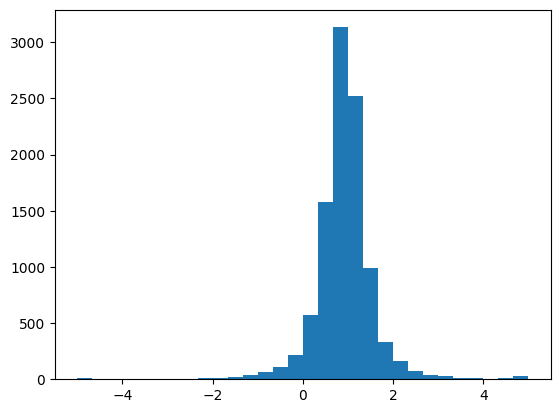

In [7]:
from prospect.models import priors_beta as pb
import numpy as np
import matplotlib.pyplot as plt

prior = pb.DymSFH(zred_mini=0.01, zred_maxi=7.0, mass_mini=7, mass_maxi=13, z_mini=-2.5, z_maxi=0.5,
                    logsfr_ratio_mini=-5, logsfr_ratio_maxi=5, logsfr_ratio_tscale=0.3, nbins_sfh=7,
                    const_phi=True)


zbins = np.arange(0, 7, 0.1)

nsamples = 10000
prior_samples = []
for i in range(nsamples):
    prior_samples.append(prior.sample())

samples = np.vstack(np.array(prior_samples))
print(samples.shape) #z, mass, met, sfrs
plt.hist(samples[:, -1], bins=30)


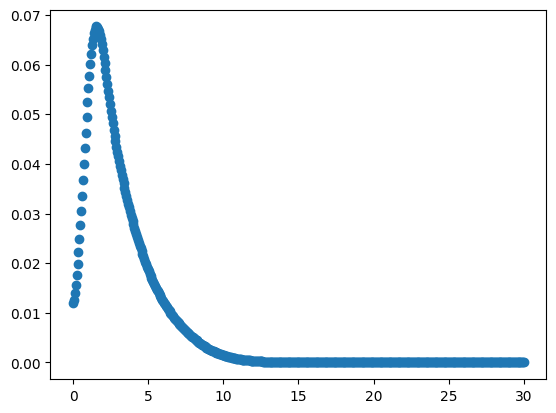

In [12]:
import matplotlib.pyplot as plt
z_b19, tl_b19, sfrd_b19 = np.loadtxt("behroozi_19_sfrd.txt", unpack=True)
plt.scatter(z_b19, sfrd_b19)
